### Import Libraries

In [55]:
import pandas as pd
import warnings
import logging
import math
import random
import os
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.svm import SVC
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from IPython.display import display
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
##from pgmpy.models import BayesianNetwork
from sklearn.ensemble import IsolationForest
#from pgmpy.inference import VariableElimination
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
#from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch, BicScore
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

### Load Dataset

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:

base_x = pd.read_csv('/content/drive/MyDrive/dataset/Base.csv')
base_x.head()

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.3               0.986506                         -1   
1           0     0.8               0.617426                         -1   
2           0     0.8               0.996707                          9   
3           0     0.6               0.475100                         11   
4           0     0.9               0.842307                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            25            40            0.006735   
1                            89            20            0.010095   
2                            14            40            0.012316   
3                            14            30            0.006991   
4                            29            40            5.742626   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0              102.453711           AA          1059  ...                0   
1               -0.849551           AD          1658  ...                0   
2               -1.490386           AB          1095  ...                0   
3               -1.863101           AB          3483  ...                0   
4               47.152498           AA          2339  ...                0   

   proposed_credit_limit  foreign_request    source  \
0                 1500.0                0  INTERNET   
1                 1500.0                0  INTERNET   
2                  200.0                0  INTERNET   
3                  200.0                0  INTERNET   
4                  200.0                0  INTERNET   

   session_length_in_minutes device_os  keep_alive_session  \
0                  16.224843     linux                   1   
1                   3.363854     other                   1   
2                  22.730559   windows                   0   
3                  15.215816     linux                   1   
4                   3.743048     other                   0   

   device_distinct_emails_8w device_fraud_count  month  
0                          1                  0      0  
1                          1                  0      0  
2                          1                  0      0  
3                          1                  0      0  
4                          1                  0      0  

[5 rows x 32 columns]

In [58]:
base = base_x.sample(frac=0.01, random_state=1)

In [59]:
display(base['fraud_bool'].value_counts())
fraud = base[base['fraud_bool']==1]
legit = base[base['fraud_bool']==0]
# fraction of fraud data against legit
outlier_fraction = len(fraud)/float(len(legit))
print(f'\nFraction of fraudulant accounts: {outlier_fraction}')
print('Fraud Cases: {}'.format(len(fraud)))
print('Legitimate Cases: {}'.format(len(legit)))

fraud_bool
0    9877
1     123
Name: count, dtype: int64


Fraction of fraudulant accounts: 0.012453174040700617
Fraud Cases: 123
Legitimate Cases: 9877


In [60]:
base['housing_status'].value_counts()

housing_status
BC    3641
BB    2651
BE    1773
BA    1659
BD     253
BF      21
BG       2
Name: count, dtype: int64

In [61]:
feature_descriptions = {
    'income' : "Annual income of the applicant (in decile form). Ranges between [0.1, 0.9].",
    'name_email_similarity' : "Metric of similarity between email and applicant’s name. Higher values represent higher similarity. Ranges between [0, 1].",
    'prev_address_months_count' : "Number of months in previous registered address of the applicant, i.e. the applicant’s previous residence, if applicable. Ranges between [−1, 380] months (-1 is a missing value).",
    'current_address_months_count' : "Months in currently registered address of the applicant. Ranges between [−1, 429] months (-1 is a missing value).",
    'customer_age' : "Applicant’s age in years, rounded to the decade. Ranges between [10, 90] years.",
    'days_since_request' : "Number of days passed since application was done. Ranges between [0, 79] days.",
    'intended_balcon_amount' : "Initial transferred amount for application. Ranges between [−16, 114] (negatives are missing values).",
    'payment_type': "Credit payment plan type. 5 possible (annonymized) values.",
    'zip_count_4w' : "Number of applications within same zip code in last 4 weeks. Ranges between [1, 6830].",
    'velocity_6h' : "Velocity of total applications made in last 6 hours i.e., average number of applications per hour in the last 6 hours. Ranges between [−175, 16818].",
    'velocity_24h' : "Velocity of total applications made in last 24 hours i.e., average number of applications per hour in the last 24 hours. Ranges between [1297, 9586].",
    'velocity_4w' : "Velocity of total applications made in last 4 weeks, i.e., average number of applications per hour in the last 4 weeks. Ranges between [2825, 7020].",
    'bank_branch_count_8w' : "Number of total applications in the selected bank branch in last 8 weeks. Ranges between [0, 2404].",
    'date_of_birth_distinct_emails_4w' : "Number of emails for applicants with same date of birth in last 4 weeks. Ranges between [0, 39].",
    'employment_status' : "Employment status of the applicant. 7 possible (annonymized) values.",
    'credit_risk_score' : "Internal score of application risk. Ranges between [−191, 389].",
    'email_is_free' : "Domain of application email (either free or paid).",
    'housing_status' : "Current residential status for applicant. 7 possible (annonymized) values.",
    'phone_home_valid' : "Validity of provided home phone.",
    'phone_mobile_valid' : "Validity of provided mobile phone.",
    'bank_months_count' : "How old is previous account (if held) in months. Ranges between [−1, 32] months (-1 is a missing value).",
    'has_other_cards' : "If applicant has other cards from the same banking company.",
    'proposed_credit_limit' : "Applicant’s proposed credit limit. Ranges between [200, 2000].",
    'foreign_request' : "If origin country of request is different from bank’s country.",
    'source' : "Online source of application. Either browser (INTERNET) or app (TELEAPP).",
    'session_length_in_minutes' : "Length of user session in banking website in minutes. Ranges between [−1, 107] minutes (-1 is a missing value).",
    'device_os' : "Operative system of device that made request. Possible values are: Windows, macOS, Linux, X11, or other.",
    'keep_alive_session' : "User option on session logout.",
    'device_distinct_emails_8w' : "Number of distinct emails in banking website from the used device in last 8 weeks. Ranges between [−1, 2] emails (-1 is a missing value).",
    'device_fraud_count' : "Number of fraudulent applications with used device. Ranges between [0, 1].",
    'month' : "Month where the application was made. Ranges between [0, 7].",
    'fraud_bool' : "If the application is fraudulent or not.1 indiates fraud and0 indicates legit"
}

In [62]:
# split numerical and categorical features
num_features = base.select_dtypes(include='number').columns.tolist()

thresh = 25

cont_feats = [feat for feat in num_features if base[feat].nunique() >= thresh]
disc_feats = [feat for feat in num_features if base[feat].nunique() < thresh]

cat_feats = base.select_dtypes(exclude='number').columns.tolist()
target_feat = disc_feats[0]
disc_feats.remove(target_feat)

cont_feats.append(disc_feats[0])
disc_feats.remove(disc_feats[0])

print(f'Features: {base.shape[1]}\n\n\
Num features: {len(num_features)}\n\
{num_features}\n\n\
Continuous: {len(cont_feats)}\n\
{cont_feats}\n\n\
Discrete: {len(disc_feats)}\n\
{disc_feats}\n\n\
Categorical: {len(cat_feats)}\n\
{cat_feats}')

print(f'\n\nTarget feature: {target_feat}')

Features: 32

Num features: 27
['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']

Continuous: 15
['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'session_length_in_minutes', 'income']

Discrete: 11
['customer_age', 'email_is_fr

### Data Preparation

In [63]:
# Encoding Categorical Variables
def encode_columns(df, categorical):
    df_encoded = df.copy()  # Create a copy of the DataFrame to work on
    le = LabelEncoder()
    for col in categorical:
        df_encoded[col] = le.fit_transform(df_encoded[col])  # Convert to string to handle any type of data
    return df_encoded

# Encode the categorical and target columns
base_encoded = encode_columns(base, cat_feats)

In [64]:
# split dataset into train and test
X = base_encoded.drop(target_feat, axis=1)
y = base_encoded[target_feat]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y , test_size = 0.2)
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(8000, 31)
(2000, 31)
(8000,)
(2000,)


## Exploratory Data Analysis

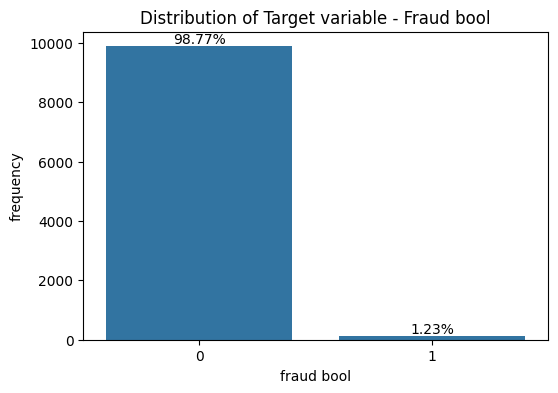

In [13]:
fig = plt.figure(figsize=(6,4))

# plot frequency of dependent variable
total_cnt = len(base)
ax = sns.countplot(x='fraud_bool', data=base)

for p in ax.patches:
    ax.annotate(f'{(p.get_height()/total_cnt)*100:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0,0), textcoords='offset points')

# Add titles and labels
ax.set_title('Distribution of Target variable - Fraud bool')
ax.set_xlabel('fraud bool')
ax.set_ylabel('frequency')

# Show the plot
plt.show();


In [14]:
def eda_cont_stats(feat):
    feature_stats = []

    for col in feat:
        missing_values = len(base[base[col] == -1])
        mean = base[col].mean()
        std = base[col].std()
        minimum = base[col].min()
        maximum = base[col].max()
        median = base[col].median()
        correlation = base_encoded.corr()['fraud_bool'][col]

        feature_stats.append({
            'Feature': col,
            'Missing Values': missing_values,
            'Mean': mean,
            'Standard Deviation': std,
            'Minimum': minimum,
            'Maximum': maximum,
            'Median': median,
            'Correlation': correlation
        })

    return feature_stats

# Create a DataFrame from the list of dictionaries
feature_stats = eda_cont_stats(cont_feats)
base_stats = pd.DataFrame(feature_stats)


In [15]:
base_stats

Feature  Missing Values         Mean  \
0              name_email_similarity               0     0.490636   
1          prev_address_months_count            7085    16.285100   
2       current_address_months_count              54    89.754900   
3                 days_since_request               0     0.965683   
4             intended_balcon_amount               0     8.631497   
5                       zip_count_4w               0  1585.025600   
6                        velocity_6h               0  5652.157818   
7                       velocity_24h               0  4762.476084   
8                        velocity_4w               0  4858.560015   
9               bank_branch_count_8w               0   181.716400   
10  date_of_birth_distinct_emails_4w               0     9.527000   
11                 credit_risk_score               6   131.372600   
12                 bank_months_count            2502    10.938200   
13         session_length_in_minutes              24     7.442889   
14                            income               0     0.556370   

    Standard Deviation       Minimum       Maximum       Median  Correlation  
0             0.287560  1.036626e-04      0.999989     0.485970    -0.021206  
1            42.583224 -1.000000e+00    350.000000    -1.000000    -0.036180  
2            91.310294 -1.000000e+00    400.000000    54.000000     0.034650  
3             4.864705  5.585994e-07     74.501902     0.015008     0.008666  
4            20.097488 -1.289510e+01    110.995814    -0.838988    -0.025321  
5          1017.997649  1.100000e+01   6066.000000  1268.000000     0.002712  
6          3027.249679  1.165740e+02  16356.364000  5295.228686    -0.024523  
7          1469.808500  1.500111e+03   9454.836970  4758.027155    -0.009456  
8           917.378550  2.983337e+03   6988.564717  4918.337969    -0.021925  
9           455.342572  0.000000e+00   2380.000000     9.000000    -0.025007  
10            5.060853  0.000000e+00     37.000000     9.000000    -0.055545  
11           70.426187 -1.480000e+02    377.000000   122.000000     0.050427  
12           12.154273 -1.000000e+00     32.000000     5.000000     0.006241  
13            7.705412 -1.000000e+00     71.410979     5.092229     0.023780  
14            0.292349  1.000000e-01      0.900000     0.600000     0.032793

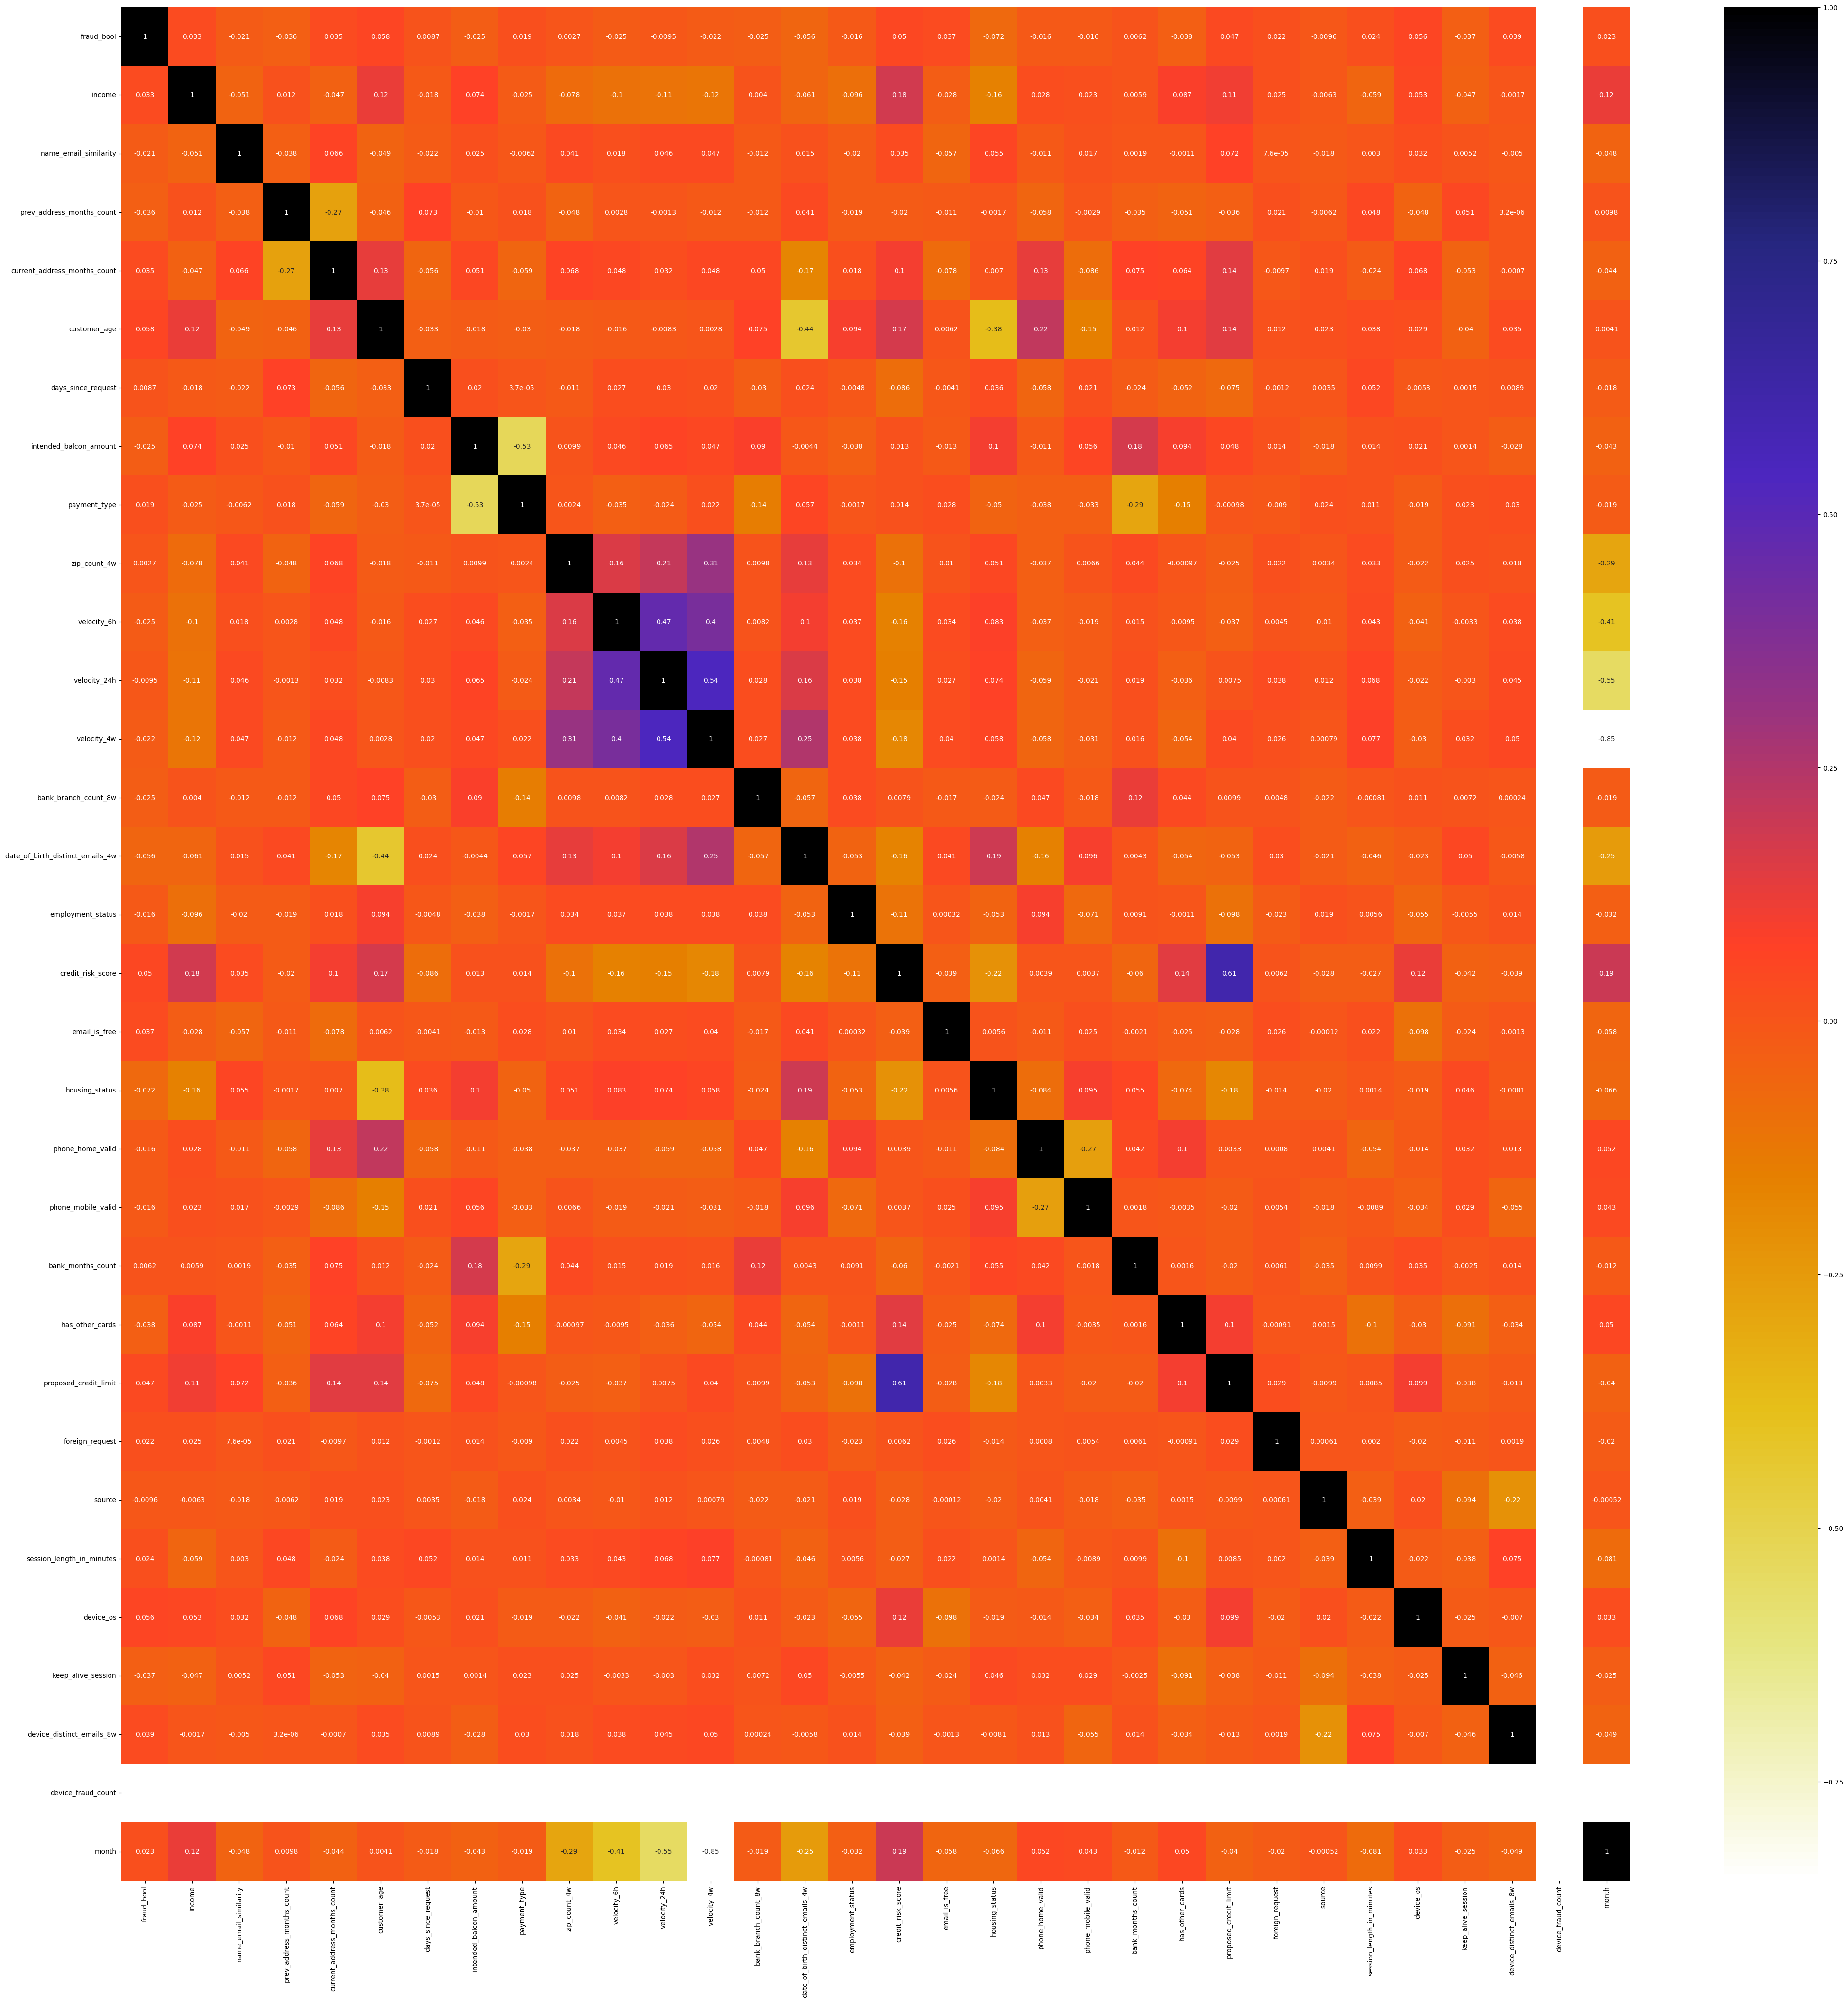

In [16]:
plt.figure(figsize=(50,50))
cor = base_encoded.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [17]:
# method to find high correlated and redundant features
def correlation(df, threshold):
  col_corr = set()
  corr_matrix = df.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i, j]) > threshold:
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr


In [18]:
corr_features = correlation(base_encoded, 0.30)
print(len(corr_features))
print(corr_features)

7
{'velocity_24h', 'housing_status', 'date_of_birth_distinct_emails_4w', 'proposed_credit_limit', 'payment_type', 'velocity_4w', 'month'}




1.   Proposed credit limit is highly correlated with credit score
2.   Different credit payment plans are designated for different amounts transferred. Hence there is a high correlation between payment types and intended balcon amount
3. Month represents the volume of applications that may be depict seasonal trends. This is correlated with the velocity of applications for 6h, 2h or 4w
4. date_of_birth_distinct_emails_4w' has a higher correlation with customer age. Possible correlation would be younger age tend to have many email accounts.
5. Device fraud count does not have any influence on any features as all the samples have the value 0





In [29]:
def plot_correlation(features):
  warnings.filterwarnings('ignore')
  plt.figure(figsize=(18, 6))
  feat1, feat2 = features
  print(f'{feat1}~{feat2}')
  sns.barplot(x=feat1, y=feat2, data=base_encoded, palette='viridis',orient='h')
  plt.xlabel(f'{feat1}')
  plt.ylabel(f'{feat2}')
  plt.title(f'Bar Plot of {feat1} vs. {feat2}')


In [34]:
def plot_correlation(features):
  warnings.filterwarnings('ignore')
  plt.figure(figsize=(18, 6))
  feat1, feat2 = features
  print(f'{feat1}~{feat2}')
  sns.barplot(x=feat1, y=feat2, data=base, palette='viridis',orient='h')
  plt.xlabel(f'{feat1}')
  plt.ylabel(f'{feat2}')
  plt.title(f'Bar Plot of {feat1} vs. {feat2}')


date_of_birth_distinct_emails_4w~customer_age


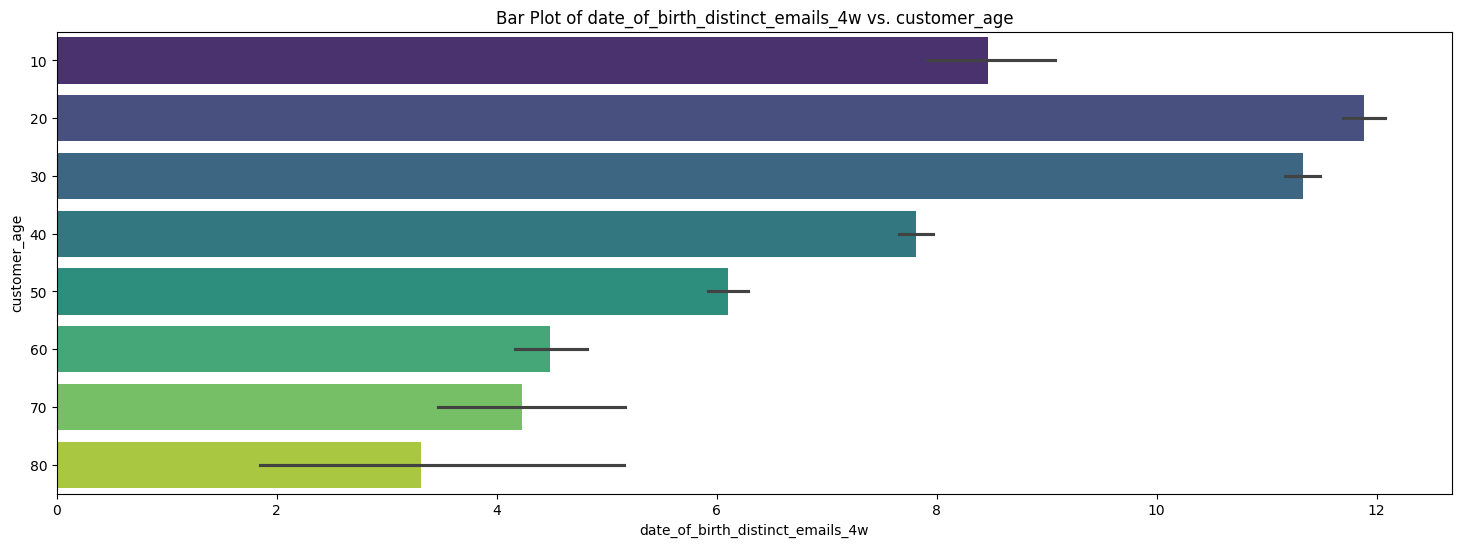

In [36]:
plot_correlation({'date_of_birth_distinct_emails_4w', 'customer_age'})

velocity_6h~month


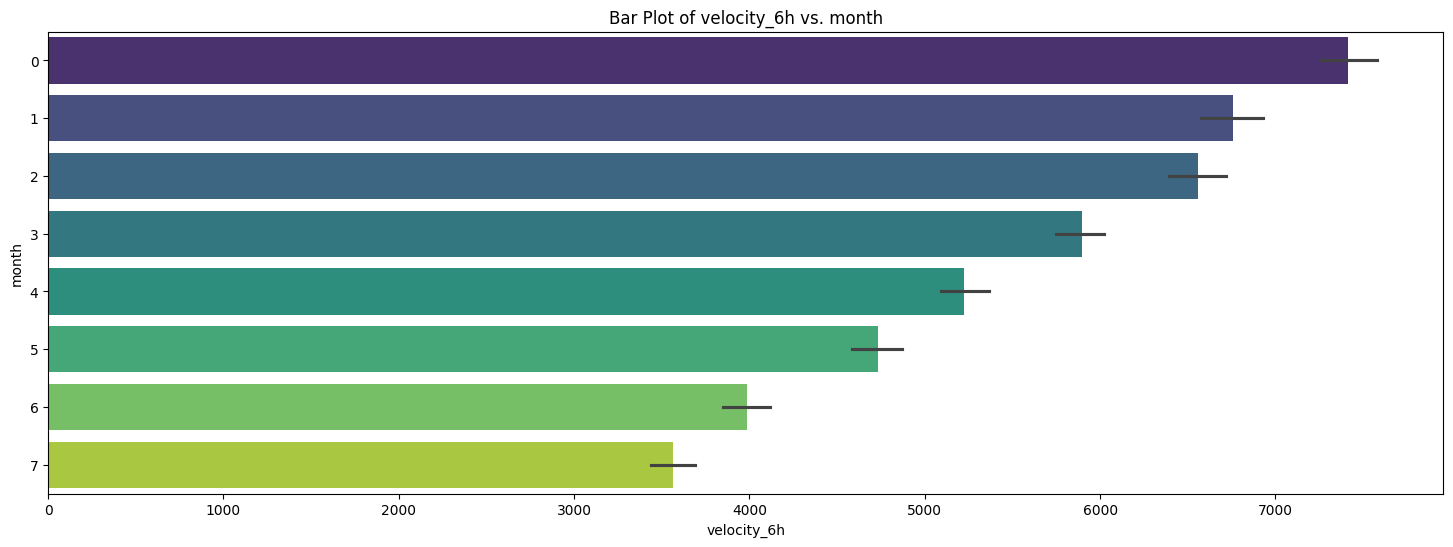

In [37]:
plot_correlation({'month','velocity_6h'})

velocity_24h~month


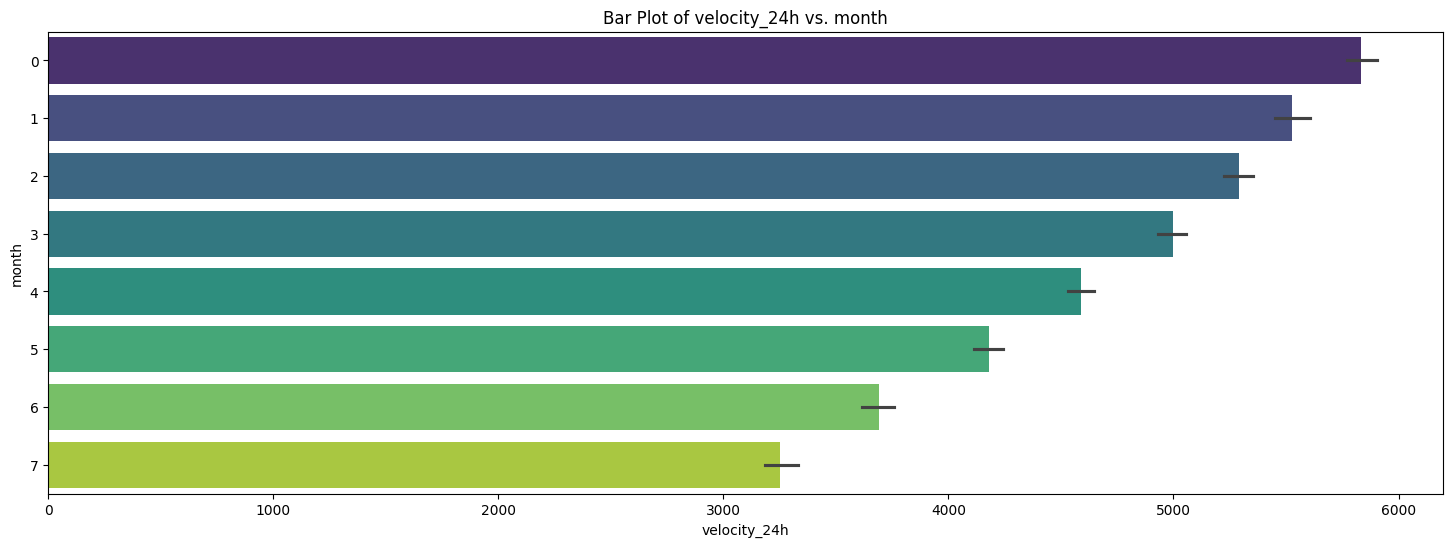

In [38]:
plot_correlation({'month','velocity_24h'})

credit_risk_score~proposed_credit_limit


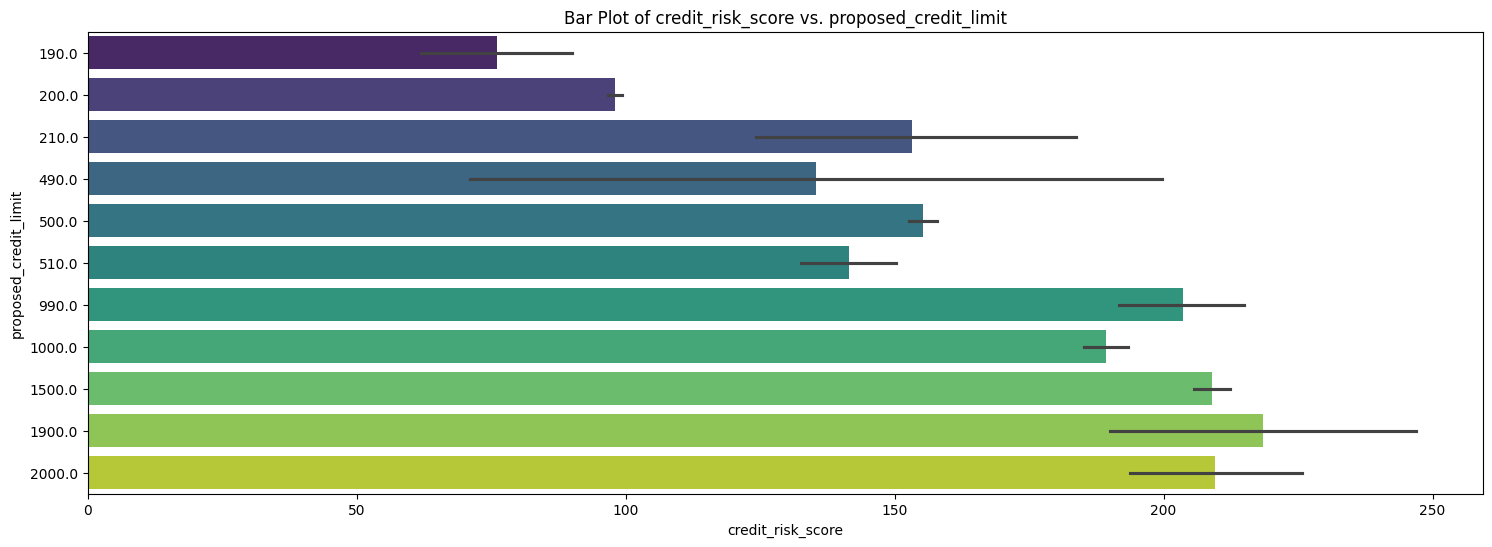

In [39]:
plot_correlation({'proposed_credit_limit','credit_risk_score'})

housing_status~payment_type


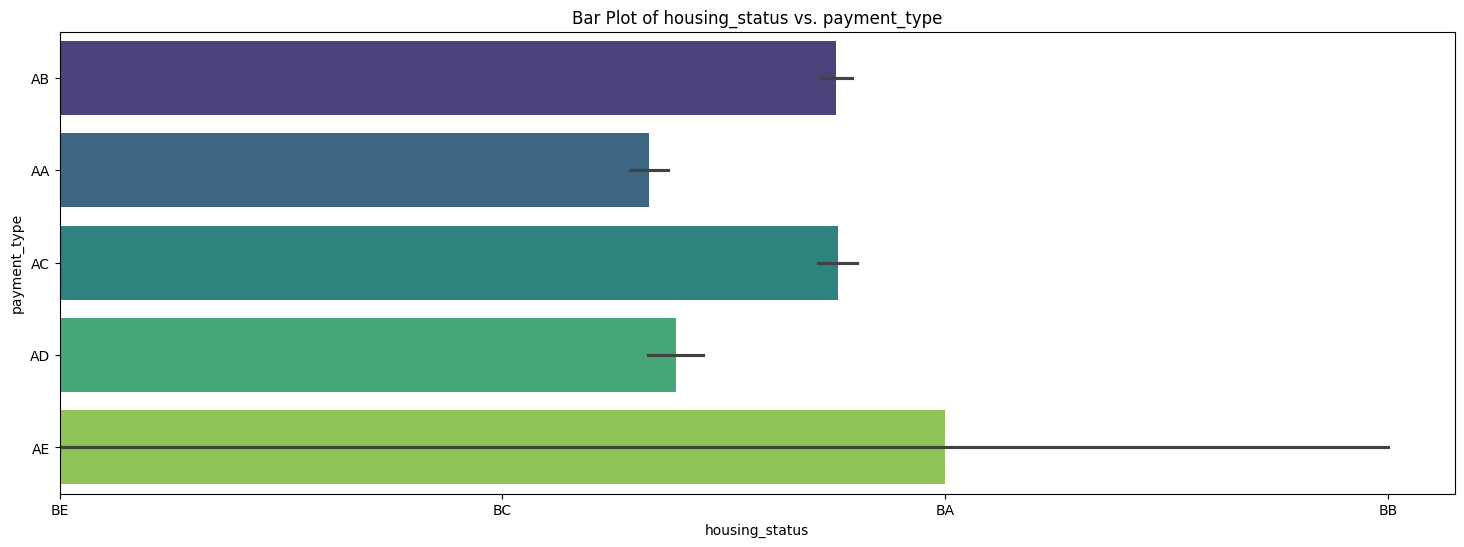

In [40]:
plot_correlation({'housing_status','payment_type'})

intended_balcon_amount~payment_type


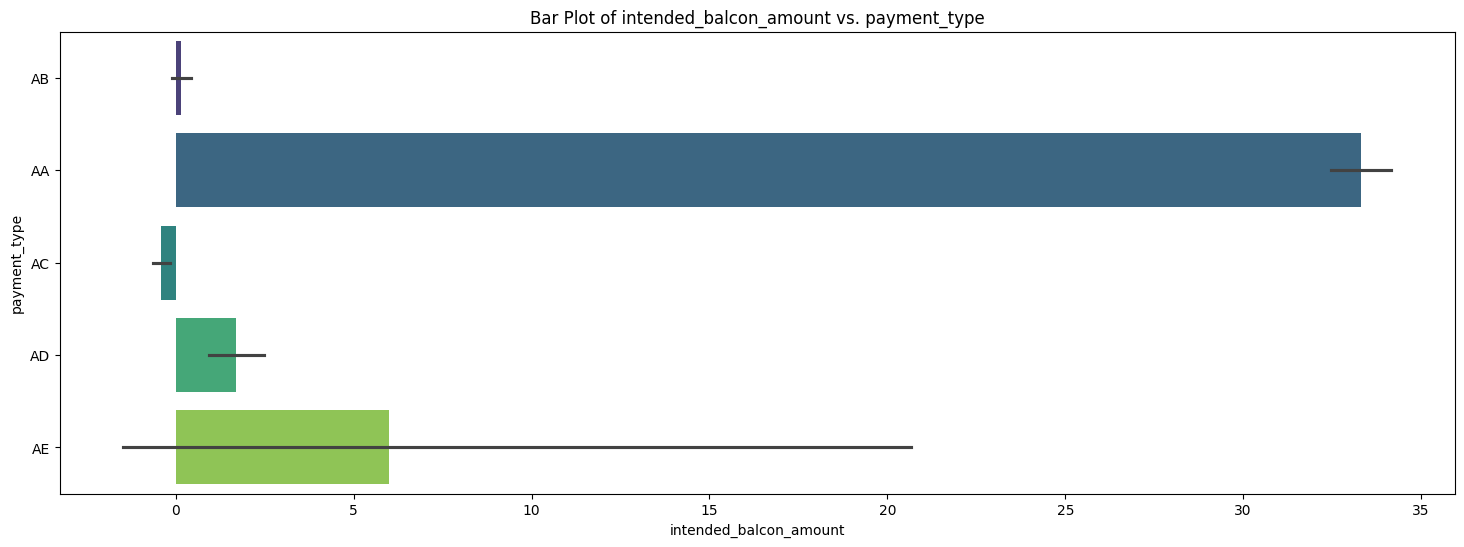

In [41]:
plot_correlation({'payment_type','intended_balcon_amount'})

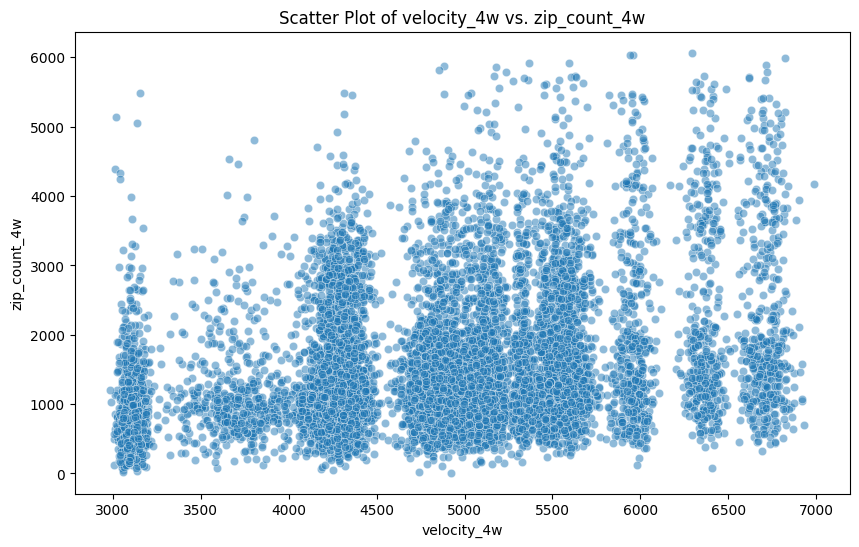

In [26]:
def plot_correlation_scatter(features):

    feat1, feat2 = features
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feat1, y=feat2, data=base_encoded, alpha=0.5)
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.title(f'Scatter Plot of {feat1} vs. {feat2}')
    plt.show()

# Example usage:
# df = pd.DataFrame({'zip_count_4w': [...], 'velocity_4w': [...]})
plot_correlation_scatter({'zip_count_4w', 'velocity_4w'})

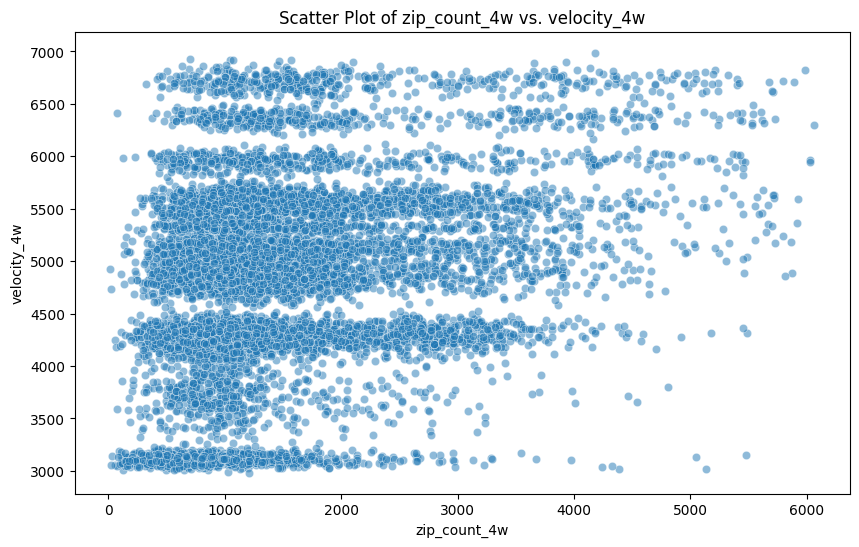

In [27]:
plot_correlation_scatter({'velocity_4w', 'zip_count_4w'})

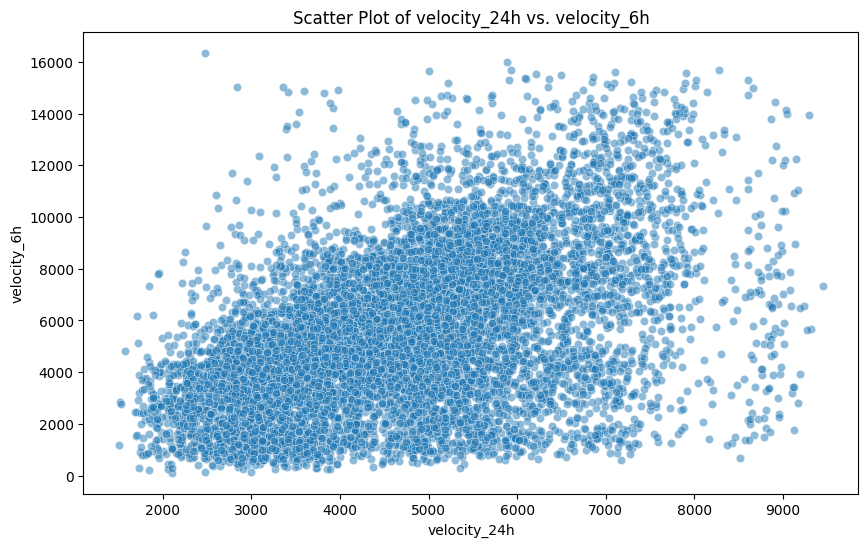

In [28]:
plot_correlation_scatter({'velocity_24h','velocity_6h'})

In [152]:
features = ['zip_count_4w','velocity_4w']
base_sort = base_encoded.sort_values(by=['zip_count_4w'])
base_encoded.head()

fraud_bool  income  name_email_similarity  prev_address_months_count  \
276826           0     0.1               0.771248                         -1   
849425           0     0.9               0.868609                         -1   
504499           0     0.6               0.461974                         30   
601054           0     0.9               0.388111                         31   
980221           0     0.9               0.512189                         -1   

        current_address_months_count  customer_age  days_since_request  \
276826                           192            20            0.008449   
849425                             8            30            0.003503   
504499                             8            30            0.006326   
601054                             2            50            0.010480   
980221                           249            50            0.013239   

        intended_balcon_amount  payment_type  zip_count_4w  ...  \
276826               -1.050951             1          2570  ...   
849425               -0.683337             1          1081  ...   
504499               -0.916832             1          2162  ...   
601054               -0.817218             1          2676  ...   
980221               -0.230889             1           621  ...   

        has_other_cards  proposed_credit_limit  foreign_request  source  \
276826                0                 1500.0                0       0   
849425                1                  200.0                0       0   
504499                0                  500.0                0       0   
601054                1                 1500.0                0       0   
980221                1                  500.0                0       0   

        session_length_in_minutes  device_os  keep_alive_session  \
276826                  37.831889          3                   0   
849425                   1.610226          0                   1   
504499                   5.502750          0                   0   
601054                   3.209488          3                   1   
980221                   8.416212          2                   1   

        device_distinct_emails_8w  device_fraud_count  month  
276826                          1                   0      2  
849425                          1                   0      6  
504499                          1                   0      3  
601054                          1                   0      4  
980221                          1                   0      7  

[5 rows x 32 columns]

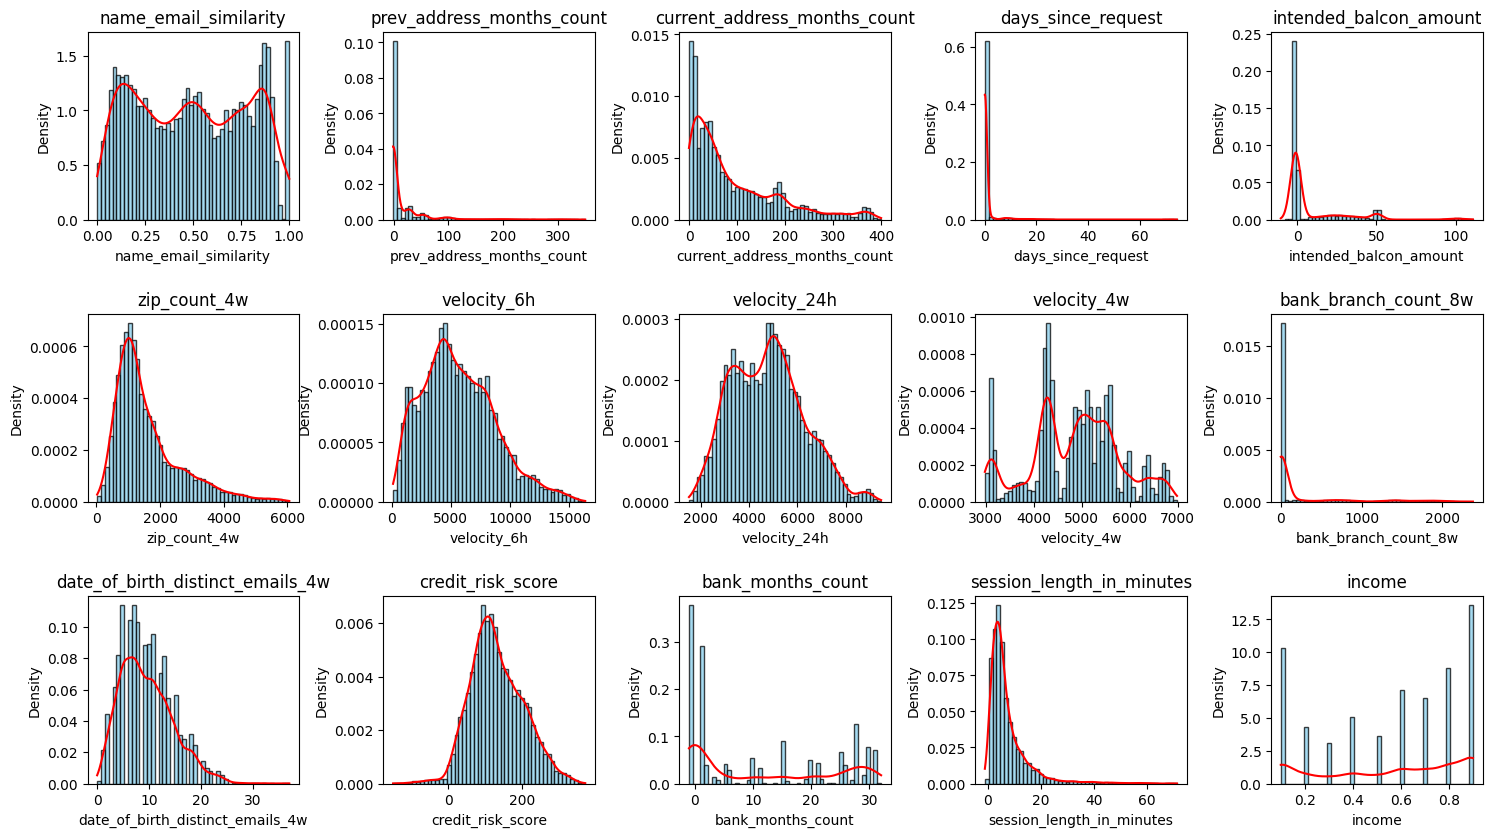

In [54]:
# create histogram with KDE plot for all teh numerical features
fig, ax = plt.subplots(3, 5, figsize=(18, 8))
plt.subplots_adjust(top = 0.99, bottom=0.05, hspace=0.5, wspace=0.4)
ax = ax.flatten()
for i,col in enumerate(cont_feats):
    kde = stats.gaussian_kde(Xtrain[col])
    x = np.linspace(Xtrain[col].min(), Xtrain[col].max(), 1000)
    ax[i].plot(x, kde(x), color='red')
    ax[i].hist(Xtrain[col], bins=50, density=True, alpha=0.75, color='skyblue', edgecolor='black')
    ax[i].set_title(f'{col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Density')

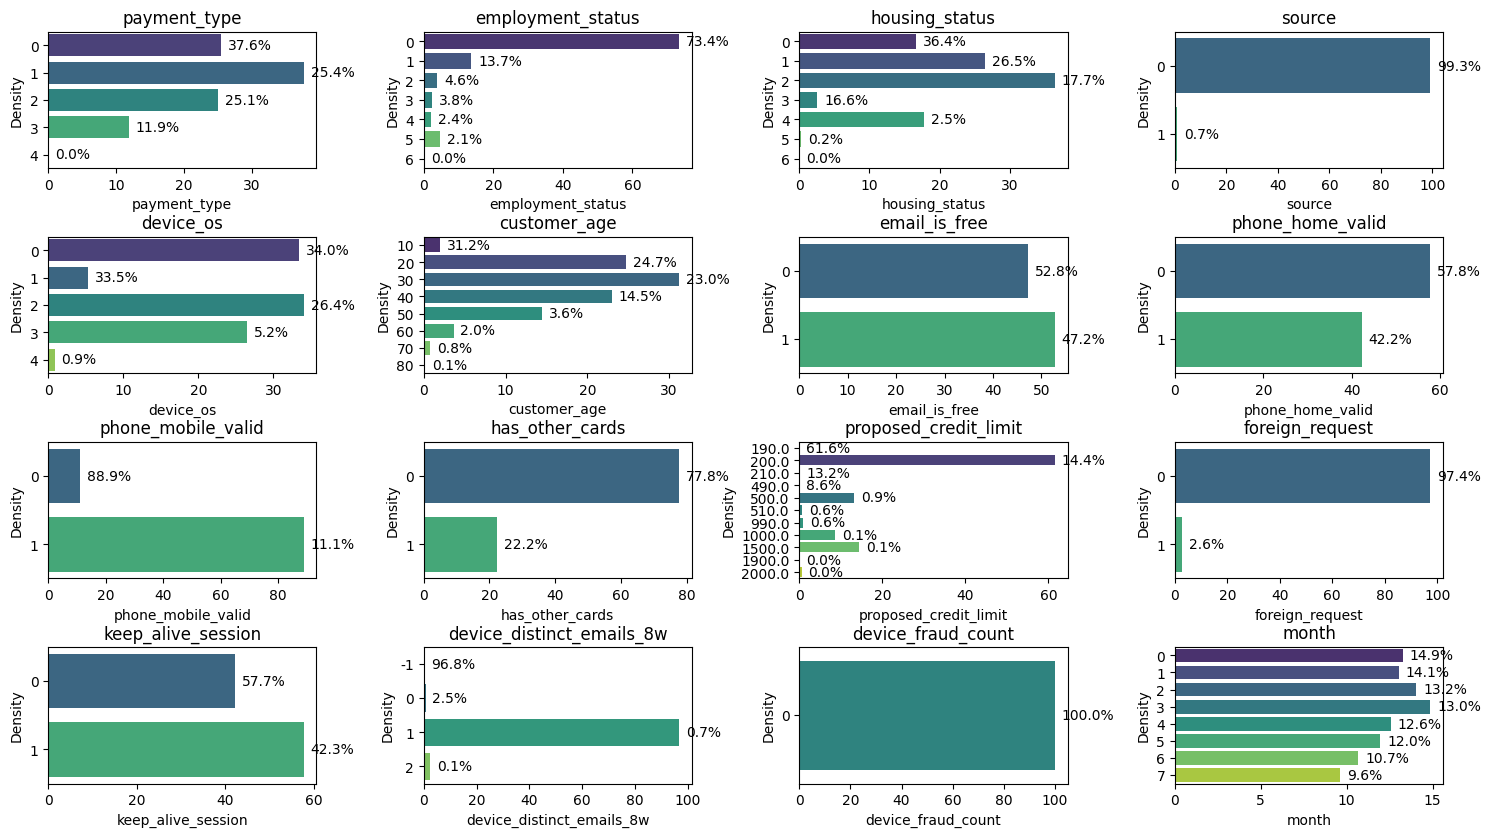

In [134]:
# create histogram with KDE plot for all teh numerical features
def eda_cat_feats(feats):
  fig, ax = plt.subplots(4, 4, figsize=(18, 8))
  plt.subplots_adjust(top = 0.99, bottom=0.05, hspace=0.5, wspace=0.4)
  ax = ax.flatten()
  for i,col in enumerate(feats):

      # Plotting horizontal bar plots on the first axis
      value_counts = base_encoded[col].value_counts()
      percent_total = value_counts / sum(value_counts) * 100
      bars = sns.barplot(x=percent_total.values, y=percent_total.index, ax=ax[i], palette='viridis', orient='h')

      # Annotating the bars with percentage values
      for bar, perc in zip(bars.patches, percent_total.values):
          ax[i].annotate(f'{perc:.1f}%',
                        xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
                        xytext=(5, 0),  # 5 points horizontal offset
                        textcoords='offset points',
                        ha='left', va='center')

      ax[i].set_title(f'{col}')
      ax[i].set_xlabel(col)
      ax[i].set_ylabel('Density')

eda_cat_feats (cat_feats+disc_feats)

In [16]:
#Strip leading and trailing whitespace from all columns
base_clean = base.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# Replace '?' with NaN and remove rows with NaN values
base_clean = base_clean.replace('?', pd.NA).dropna()
base_clean[cont_feats] = base_clean[cont_feats].replace(-1, pd.NA).dropna()

base_clean.shape

(10000, 32)

## Feature Engineering

## Classification Algorithms

### Clustering

Silhouette Score: 0.07237196132393381
Confusion Matrix:
[[3887 4016]
 [  59   38]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.49      0.66      7903
           1       0.01      0.39      0.02        97

    accuracy                           0.49      8000
   macro avg       0.50      0.44      0.34      8000
weighted avg       0.97      0.49      0.65      8000



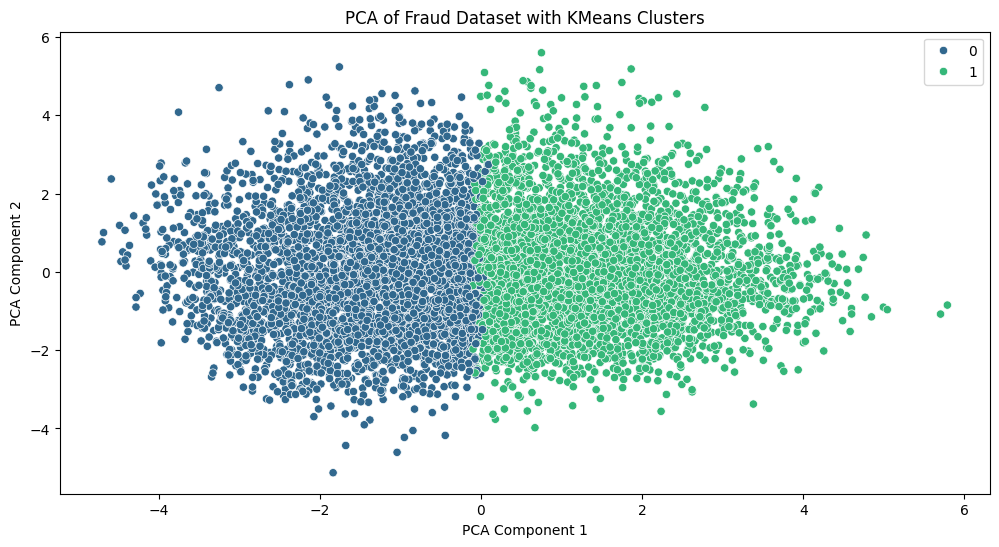

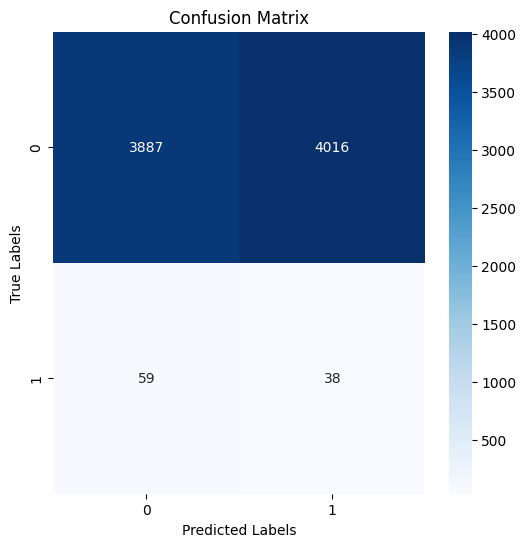

In [47]:



# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xtrain)

# Apply PCA for dimensionality reduction (for visualization purposes)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Evaluate clustering performance
sil_score = silhouette_score(X_scaled, clusters)
print(f'Silhouette Score: {sil_score}')

# Map clusters to the actual labels (this might need adjustment)
# Assuming cluster 0 is legitimate and cluster 1 is fraud
labels = np.zeros_like(clusters)
labels[clusters == 1] = 1

# Evaluate with confusion matrix and classification report
cm = confusion_matrix(ytrain, labels)
cr = classification_report(ytrain, labels)

print('Confusion Matrix:')
print(cm)
print('\nClassification Report:')
print(cr)

# Plot PCA results with clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', legend='full')
plt.title('PCA of Fraud Dataset with KMeans Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [73]:
# drop high correlation and redundant features
# {'date_of_birth_distinct_emails_4w', 'velocity_24h', 'month', 'proposed_credit_limit', 'housing_status', 'velocity_4w', 'payment_type'}

drop_columns = ['velocity_24h','date_of_birth_distinct_emails_4w','proposed_credit_limit','velocity_4w','velocity_6h', 'device_fraud_count']

for col in drop_columns:
    Xtrain_clean = Xtrain.drop(col, axis=1)
Xtrain_clean.head()

income  name_email_similarity  prev_address_months_count  \
947256     0.6               0.561721                         93   
45227      0.6               0.175284                         -1   
521607     0.3               0.472767                         -1   
576546     0.2               0.843098                         -1   
521319     0.1               0.776963                         -1   

        current_address_months_count  customer_age  days_since_request  \
947256                            11            40            0.015901   
45227                            143            50            0.004661   
521607                            50            40            0.017481   
576546                            43            30            0.012819   
521319                            28            40            0.005201   

        intended_balcon_amount  payment_type  zip_count_4w  velocity_6h  ...  \
947256               -0.630504             1          1169  3606.548331  ...   
45227                51.809645             0          2035  2524.985281  ...   
521607               -0.923070             1           754  5666.718963  ...   
576546               -0.989060             1          1048  6410.407404  ...   
521319               -1.267950             1          1864  9360.621487  ...   

        bank_months_count  has_other_cards  proposed_credit_limit  \
947256                  1                0                  500.0   
45227                  25                0                  200.0   
521607                 10                1                  200.0   
576546                 -1                0                  200.0   
521319                  1                1                  200.0   

        foreign_request  source  session_length_in_minutes  device_os  \
947256                0       0                   2.307495          2   
45227                 0       0                   3.312481          4   
521607                0       0                   1.409500          0   
576546                0       0                   2.992759          2   
521319                0       0                   3.054767          2   

        keep_alive_session  device_distinct_emails_8w  month  
947256                   1                          1      7  
45227                    1                          1      0  
521607                   0                          1      3  
576546                   1                          1      4  
521319                   0                          0      3  

[5 rows x 30 columns]

In [94]:
len(ytrain[ytrain[:]==1])

104

In [95]:
from imblearn.over_sampling import SMOTE
import pandas as pd


# Calculate the number of fraud accounts after oversampling
n_legit = len(ytrain[ytrain[:]==0])
n_fraud = 0.75 * n_legit

# Using SMOTE to oversample fraud accounts
smote = SMOTE(sampling_strategy={1: int(n_fraud)})
X_smote, y_smote = smote.fit_resample(Xtrain, ytrain)

# Combine the resampled features and labels into a new DataFrame
base_smote = pd.concat([X_smote, y_smote], axis=1)
print(f'Shape of the resampled data: {base_smote.shape}')
print(base_smote['fraud_bool'].value_counts())


Shape of the resampled data: (13818, 32)
fraud_bool
0    7896
1    5922
Name: count, dtype: int64


In [96]:
# split dataset into train and test
X = base_smote.drop(target_feat, axis=1)
y = base_smote[target_feat]

Xtrain_smote, Xtest_smote, ytrain_smote, ytest_smote = train_test_split(X, y , test_size = 0.2)
print(Xtrain_smote.shape)
print(Xtest_smote.shape)
print(ytrain_smote.shape)
print(ytest_smote.shape)

(11054, 31)
(2764, 31)
(11054,)
(2764,)


Silhouette Score: 0.09324349333068148
Confusion Matrix:
[[2492 3824]
 [3362 1376]]

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.39      0.41      6316
           1       0.26      0.29      0.28      4738

    accuracy                           0.35     11054
   macro avg       0.35      0.34      0.34     11054
weighted avg       0.36      0.35      0.35     11054



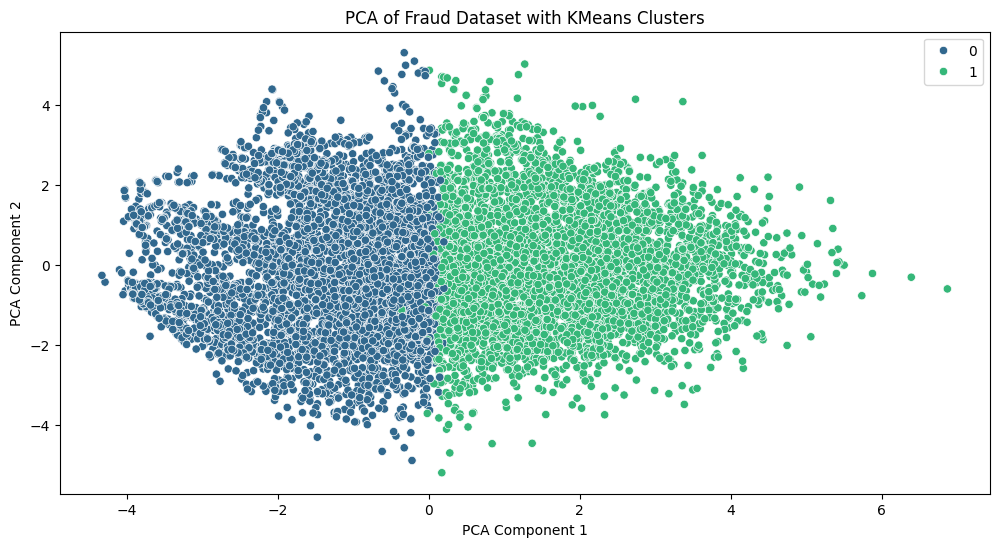

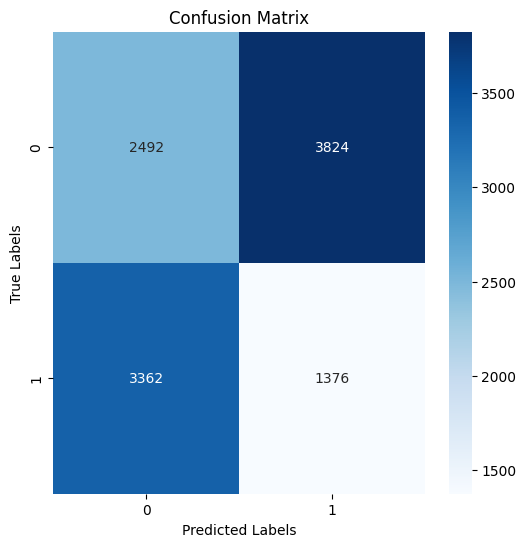

In [97]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xtrain_smote)

# Apply PCA for dimensionality reduction (for visualization purposes)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Evaluate clustering performance
sil_score = silhouette_score(X_scaled, clusters)
print(f'Silhouette Score: {sil_score}')

# Map clusters to the actual labels (this might need adjustment)
# Assuming cluster 0 is legitimate and cluster 1 is fraud
labels = np.zeros_like(clusters)
labels[clusters == 1] = 1

# Evaluate with confusion matrix and classification report
cm = confusion_matrix(ytrain_smote, labels)
cr = classification_report(ytrain_smote, labels)

print('Confusion Matrix:')
print(cm)
print('\nClassification Report:')
print(cr)

# Plot PCA results with clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', legend='full')
plt.title('PCA of Fraud Dataset with KMeans Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Anomaly Detection

In [22]:
def displayReport(clf_name, y, y_pred):
    # Adjust y_pred to match binary classification format
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    print(f"{clf_name}: {n_errors}")
    print("Accuracy Score :")
    print(accuracy_score(y, y_pred))
    print('Classification Report: ')
    print(classification_report(y, y_pred))

In [26]:
# Define the parameter grid
param_grid_lof = {
    'n_neighbors': [10, 20, 30],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 40],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1,2],
    'contamination': [0.05, 0.1]
}


# Define parameter grid for Isolation Forest
param_grid_if = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 0.5, 0.75, 1.0],
    'contamination': [0.01, 0.05, 0.1, 0.2],
    'max_features': [1.0, 0.5, 0.75],
    'bootstrap': [False, True]
}

# Define parameter grid for OneClassSVM
param_grid_svm = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'nu': [0.01, 0.05, 0.1, 0.5]
}

# Custom scoring function
def custom_scorer(y_true, y_pred):
    y_pred = np.where(y_pred == 1, 0, 1)
    return accuracy_score(y_true, y_pred)

# Make scorer
scorer = make_scorer(custom_scorer)

### Local Outlier Factor

In [27]:
warnings.filterwarnings('ignore')
# Initialize the model
lof = LocalOutlierFactor(novelty=True)
# Perform Grid Search
grid_search = GridSearchCV(estimator=lof, param_grid=param_grid_lof, scoring=scorer, cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(Xtrain)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the final model with best parameters
best_lof = LocalOutlierFactor(**best_params)
y_pred = best_lof.fit_predict(Xtest)
displayReport('Local Outlier', y, y_pred)

Best Parameters: {'algorithm': 'auto', 'contamination': 0.05, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10, 'p': 1}
Best Score: nan
Local Outlier: 609
Accuracy Score :
0.9391
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      9877
           1       0.01      0.06      0.02       123

    accuracy                           0.94     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.98      0.94      0.96     10000



In [ ]:
warnings.filterwarnings('ignore')
# Initialize the model
lof = LocalOutlierFactor(novelty=True)
# Perform Grid Search
grid_search = GridSearchCV(estimator=lof, param_grid=param_grid_lof, scoring=scorer, cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(X)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the final model with best parameters
best_lof = LocalOutlierFactor(**best_params)
y_pred = best_lof.fit_predict(X)
displayReport('Local Outlier', y, y_pred)

### Isolation Forest

In [28]:
# Initialize the model
clf_if = IsolationForest(random_state=42, verbose=0)

grid_search_if = GridSearchCV(estimator=clf_if, param_grid=param_grid_if, scoring=scorer, cv=5, n_jobs=-1)
grid_search_if.fit(X, y)


# Get the best parameters and best score
best_params_if = grid_search_if.best_params_
best_score_if = grid_search_if.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the final Isolation Forest model with best parameters
best_isolation_forest = IsolationForest(**best_params_if, random_state=42)
y_pred_if = best_isolation_forest.fit_predict(X)
displayReport('Isolation Forest',y, y_pred_if)

Best Parameters: {'algorithm': 'auto', 'contamination': 0.05, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10, 'p': 1}
Best Score: nan
Isolation Forest: 219
Accuracy Score :
0.9781
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9877
           1       0.02      0.02      0.02       123

    accuracy                           0.98     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.98      0.98      0.98     10000



In [37]:
# Resampling using SMOTE
# Apply SMOTE to the training data only

# SMOTE resampling
print(X.shape)
print(y.shape)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# concat the two datasets
base_smote = pd.concat([X_smote, y_smote], axis=1)
print(f'Shape of the resampled data: {base_smote.shape}')

(10000, 31)
(10000,)
Shape of the resampled data: (19754, 32)


In [38]:
base_smote['fraud_bool'].value_counts()

fraud_bool
0    9877
1    9877
Name: count, dtype: int64

In [29]:
# Standardize features for SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

one_class_svm = OneClassSVM(max_iter=-1)

# Perform Grid Search for OneClassSVM
grid_search_svm = GridSearchCV(estimator=one_class_svm, param_grid=param_grid_svm, scoring=scorer, cv=5, n_jobs=-1)
grid_search_svm.fit(X_scaled, y)
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_
warnings.filterwarnings('ignore')

print(f"Best Parameters for OneClassSVM: {best_params_svm}")
print(f"Best Score for OneClassSVM: {best_score_svm}")

# Train the final OneClassSVM model with best parameters
best_one_class_svm = OneClassSVM(**best_params_svm, max_iter=-1)
y_pred_svm = best_one_class_svm.fit_predict(X_scaled)
displayReport('One class SVM',y, y_pred_svm)

Best Parameters for OneClassSVM: {'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid', 'nu': 0.01}
Best Score for OneClassSVM: 0.9804999999999999
One class SVM: 216
Accuracy Score :
0.9784
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9877
           1       0.05      0.04      0.04       123

    accuracy                           0.98     10000
   macro avg       0.52      0.52      0.52     10000
weighted avg       0.98      0.98      0.98     10000



## Clustering

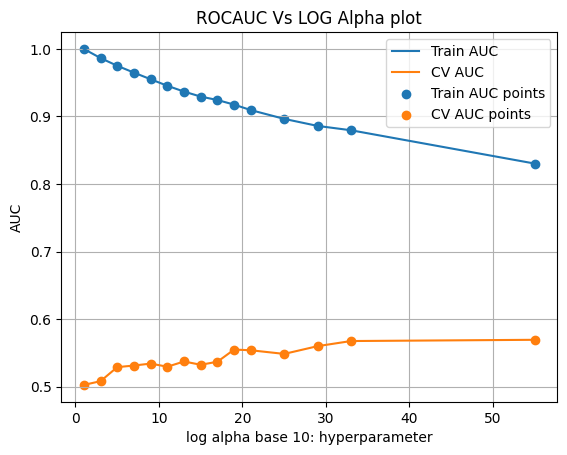

{'n_neighbors': 55}
0.5693008918149005


In [33]:

neigh = KNeighborsClassifier(n_jobs=-1)

k=np.array([1,3,5,7,9,11,13,15,17,19,21,25,29,33,55]) # Different k values
tuned_parameters = {'n_neighbors' : k} # k values in a dictionary


clf = GridSearchCV(neigh, tuned_parameters, cv=5, scoring='roc_auc',return_train_score=True)
clf.fit(X_train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)

#  gridsearchcv execution will understand. concepts required KFold cross validation
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']

cv_auc = results['mean_test_score']

k =  results['param_n_neighbors']



plt.plot(k, train_auc, label='Train AUC')# to connect lines to auc points


plt.plot(k, cv_auc, label='CV AUC')



plt.scatter(k, train_auc, label='Train AUC points')
plt.scatter(k, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log alpha base 10: hyperparameter")
plt.ylabel("AUC")
plt.title("ROCAUC Vs LOG Alpha plot")
plt.grid()
plt.show()


print(clf.best_params_)# pick the best alpha value
print(clf.best_score_)


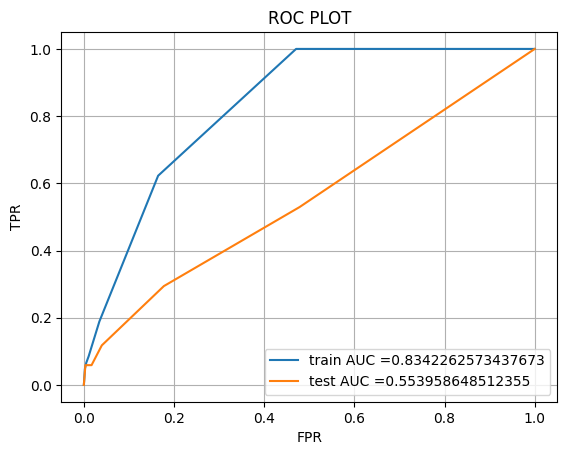

---------------------------------------------------
the maximum value of tpr*(1-fpr) 0.5292627311882443 for threshold 0.018
Train confusion matrix


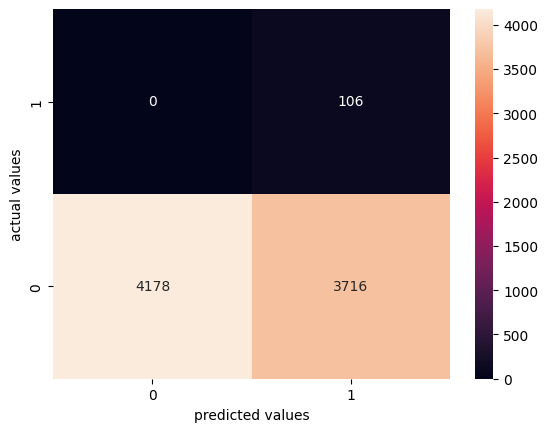

Test confusion matrix


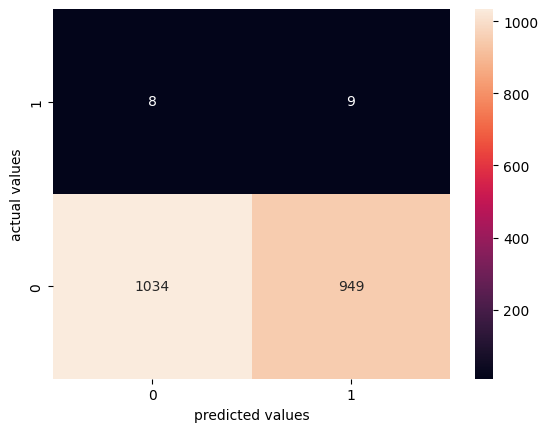

In [34]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

neigh = KNeighborsClassifier(n_neighbors=55)
neigh.fit(X_train, y_train)



y_train_pred = neigh.predict_proba(X_train)[:,1]
y_test_pred = neigh.predict_proba(X_test)[:,1]
#print(y_test_pred)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]

    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("---------------------------------------------------")


from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")

ax = sns.heatmap(confusion_matrix(y_train, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx=sns.heatmap(confusion_matrix(y_test, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Assuming df is your DataFrame
X = base.drop(columns=['fraud_bool'])
y = base['fraud_bool']

# Encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model (assuming GaussianNB for simplicity)
model = GaussianNB()
model.fit(X_train, y_train)


GaussianNB()

In [ ]:
y_pred = model.predict(X_test)
y_pred

In [36]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))


ValueError: Found input variables with inconsistent numbers of samples: [2000, 10000]

In [ ]:
# Feature importance can be approximated by looking at the mean and variance of each feature for each class
import numpy as np

feature_importance = np.exp(model.theta_[1]) - np.exp(model.theta_[0])
important_features = np.argsort(feature_importance)[::-1]

print("Important features in predicting fraud:")
for i in important_features:
    print(X.columns[i], ":", feature_importance[i])
